In [1]:
import torch.nn.functional as F
import torch
import torchvision
from torch import nn
from torch.utils import data
from d2l import torch as d2l

class MLP(nn.Module):
    def __init__(self, dim, hid_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hid_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hid_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class TokenMixing(nn.Module):
    def __init__(self, dim, patch_num, token_mix):
        super().__init__()
        self.layernorm = nn.LayerNorm(dim)

        self.tokenmix = MLP(patch_num, token_mix)

    def forward(self, x):
        x = self.layernorm(x)  # bs, n, c -> bs, c ,n
        x = x.transpose(1, 2)
        x = self.tokenmix(x)
        x = x.transpose(1, 2)  # bs,n , c
        return x


class ChannelMixing(nn.Module):
    def __init__(self, dim, channel_mix):
        super().__init__()
        self.layernorm = nn.LayerNorm(dim)
        self.channelmix = MLP(dim, channel_mix)

    def forward(self, x):
        x = self.layernorm(x)
        x = self.channelmix(x)
        return x


class MLPMixer(nn.Module):
    def __init__(self, in_channels, dim, token_mix, channel_mix, img_size=32, patch_size=4, depth=8, num_classes=10):
        super().__init__()
        assert img_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        self.num_patch = (img_size // patch_size) ** 2

        self.dim = dim
        self.conv = nn.Conv2d(in_channels, dim, patch_size, patch_size)
        self.module_list = nn.ModuleList([])

        for _ in range(depth):
            self.module_list.append(TokenMixing(dim, self.num_patch, token_mix))
            self.module_list.append(ChannelMixing(dim, channel_mix))

        self.layernorm = nn.LayerNorm(dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        bs = x.size(0)
        x = self.conv(x)  # bs, c, h, w

        x = x.view(bs, self.dim, -1)
        x = x.transpose(1, 2)  # bs, (h, w), c

        for mixer_block in self.module_list:
            x = mixer_block(x)

        x = self.layernorm(x)
        x = x.mean(dim=1)

        return self.mlp_head(x)

In [2]:
def load_data_cifar100(batch_size=128):
    transform_train = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize(40),
        torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                 ratio=(1.0, 1.0)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    transform_test = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=0)
    return trainloader, testloader


def train_batch(net, X, y, loss, trainer, devices):
    X = X.to(devices)
    y = y.to(devices)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period,
          lr_decay, use_sl=True, device=d2l.try_gpu()):
    if use_sl:
        scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = net.to(device)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss,
                                 trainer, device)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = evaluate_accuracy(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        if use_sl:
            scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                     f' examples/sec on {str(device)}')


def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


def train_fine_tuning(net, learning_rate, lr_period, lr_decay, train_iter, valid_iter, loss, num_epochs=5,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period, lr_decay)

train loss 0.077, train acc 0.981, valid acc 0.317
3475.4 examples/sec on cuda:0


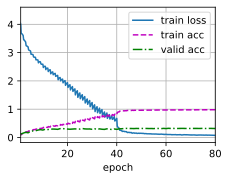

In [3]:
net = MLPMixer(in_channels=3, dim=256, token_mix=128, channel_mix=1024, img_size=32, patch_size=4, depth=8,
               num_classes=100)
devices = d2l.try_gpu()
num_epochs = 80
lr = 2e-4
wd = 5e-4
lr_period = 40
lr_decay = 0.1
trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
torch.save(net.state_dict(), "mlp_mixer.pth", _use_new_zipfile_serialization=True)